<a href="https://colab.research.google.com/github/alecbidaran/Pytorch_excersies/blob/main/pytorch_gradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
if not os.path.exists('cell_images'):
    !pip install -U -q torch_snippets
    !wget -q ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip
    !unzip -qq cell_images.zip
    !rm cell_images.zip
from torch_snippets import *

     |████████████████████████████████| 215kB 11.9MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 


2021-07-03 09:54:47.753 | WARNING  | torch_snippets.torch_loader:<module>:233 - Not importing Lightning Report
2021-07-03 09:54:48.327 | WARNING  | torch_snippets:<module>:13 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


In [ ]:
id2int = {'Parasitized': 0, 'Uninfected': 1}

In [ ]:
from torchvision import transforms

trn_trfs=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ColorJitter(
        brightness=(0.95,1.05),
        contrast=(0.95,1.05),
        saturation=(0.95,1.05), 
        hue=0.05 ),
    transforms.RandomAffine(5,translate=(0.01,0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
])
test_trfs=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
])

In [ ]:
import torch

In [ ]:
class MalariaImages(torch.utils.data.Dataset):
  def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))
  def __len__(self):
    return len(self.files)
  def __getitem__(self,ix):
    files=self.files[ix]
    classes=fname(parent(files))
    img=read(files,1)
    return img,classes
  def collate_fn(self, batch):
        _imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in _imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes, _imgs


In [ ]:
import glob
import numpy as np 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files=glob.glob("/content/cell_images/*/*.png")
np.random.seed(10)
np.random.shuffle(all_files)


In [ ]:
from sklearn.model_selection import train_test_split
train_file,val_files=train_test_split(all_files,test_size=0.2,random_state=True)

In [ ]:
trn_ds = MalariaImages(train_file, transform=trn_trfs)
val_ds = MalariaImages(val_files, transform=test_trfs)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

2021-07-03 09:55:44.759 | INFO     | __main__:__init__:5 - 22046
2021-07-03 09:55:44.762 | INFO     | __main__:__init__:5 - 5512


In [ ]:
def convBlock(ni, no):
    return torch.nn.Sequential(
        torch.nn.Dropout(0.2),
        torch.nn.Conv2d(ni, no, kernel_size=3, padding=1),
        torch.nn.ReLU(inplace=True),
        torch.nn.BatchNorm2d(no),
        torch.nn.MaxPool2d(2),
    )
class Convblock(torch.nn.Module):
   def __init__(self):
        super().__init__()
        self.network=torch.nn.Sequential(
            convblock(3,64),
            convblock(64,64),
            convblock(64,128),
            convblock(128,256),
            convblock(256,512),
            convblock(512,64),
            torch.nn.Flatten(),
            torch.nn.Linear(256,256),
            torch.nn.Dropout(0.2),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(256,len(id2int)))
        self.loss_fn=torch.nn.CrossEntropyLoss()
   def forward(self,x):
      return self.network(x)
   def compute_metrics(self,preds,trues):
     loss=self.loss_fn(preds,trues)
     acc=(torch.max(preds,1)[1]==trues).float().mean()
     return loss,acc


In [ ]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, labels, _ = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, labels, _ = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()

In [ ]:
model = Convblock().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 2

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)

EPOCH: 1.000	trn_loss: 0.226	trn_acc: 0.918	val_loss: 0.172	val_acc: 0.948	(127.89s - 127.89s remaining)
EPOCH: 2.000	trn_loss: 0.171	trn_acc: 0.946	val_loss: 0.147	val_acc: 0.952	(254.85s - 0.00s remaining)


In [ ]:
im2fmap = nn.Sequential(*(list(model.network[:5].children()) + list(model.network[5][:2].children())))

In [ ]:
print(im2cam)

Sequential(
  (0): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [ ]:
model.network[-6][1]

Conv2d(512, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [ ]:
def im2gradCAM(x):
    model.eval()
    logits = model(x)
    heatmaps = []
    activations = im2fmap(x)
    print(activations.shape)
    pred = logits.max(-1)[-1]
    # get the model's prediction
    model.zero_grad()
    # compute gradients with respect to model's most confident logit
    logits[0,pred].backward(retain_graph=True)
    # get the gradients at the required featuremap location
    # and take the avg gradient for every featuremap
    pooled_grads = model.network[-6][1].weight.grad.data.mean((1,2,3))
    # multiply each activation map with corresponding gradient average
    for i in range(activations.shape[1]):
        activations[:,i,:,:] *= pooled_grads[i]
    # take the mean of all weighted activation maps
    # (that has been weighted by avg. grad at each fmap)
    acts=torch.abs(activations)
    heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
    return heatmap, 'Uninfected' if pred.item() else 'Parasitized'


In [ ]:
import cv2 

In [ ]:
SZ = 128
def upsampleHeatmap(map, img):
    m,M = map.min(), map.max()
    map = 255 * ((map-m) / (M-m))
    map = np.uint8(map)
    map = cv2.resize(map, (SZ,SZ))
    map = cv2.applyColorMap(map,cv2.COLORMAP_HOT)
    grey=cv2.cvtColor(map,cv2.COLOR_BGR2GRAY)
    _,thresh=cv2.threshold(grey,210,255,cv2.THRESH_BINARY)
    map = cv2.addWeighted(image,0.5,map,0.5,0)
    return map,thresh

torch.Size([1, 64, 4, 4])


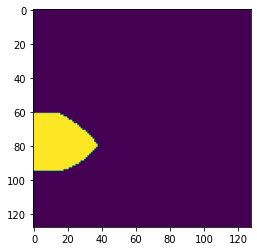

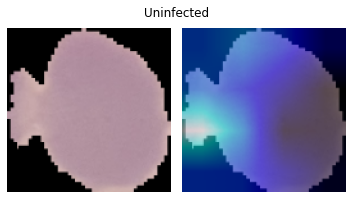

torch.Size([1, 64, 4, 4])


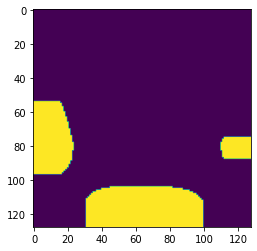

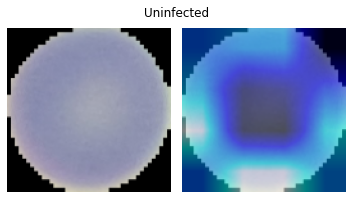

torch.Size([1, 64, 4, 4])


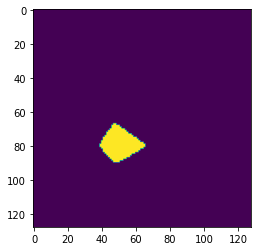

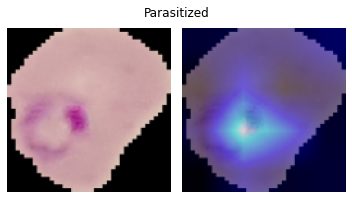

torch.Size([1, 64, 4, 4])


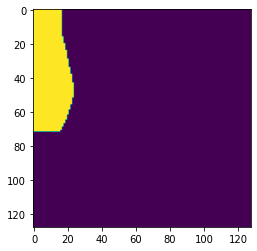

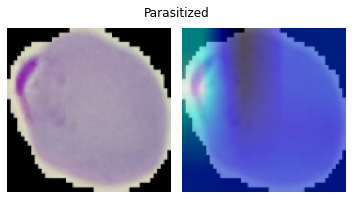

torch.Size([1, 64, 4, 4])


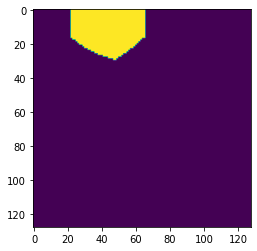

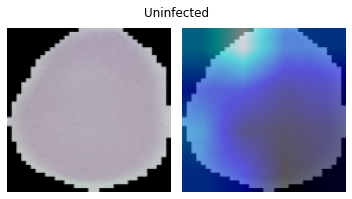

torch.Size([1, 64, 4, 4])


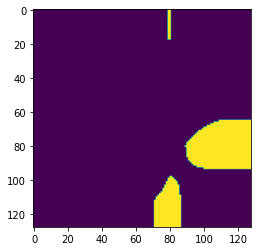

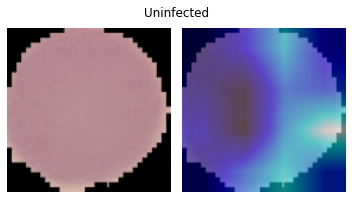

torch.Size([1, 64, 4, 4])


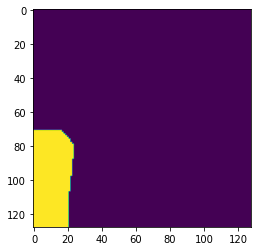

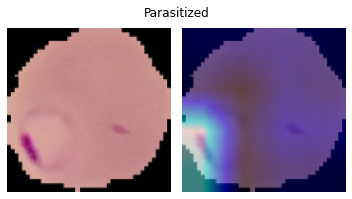

torch.Size([1, 64, 4, 4])


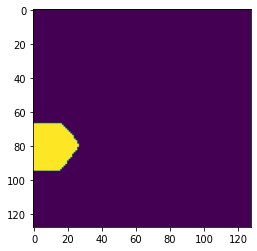

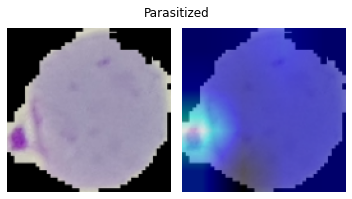

torch.Size([1, 64, 4, 4])


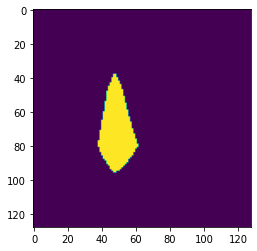

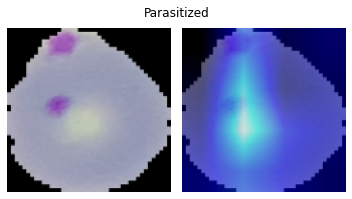

torch.Size([1, 64, 4, 4])


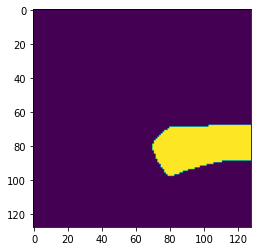

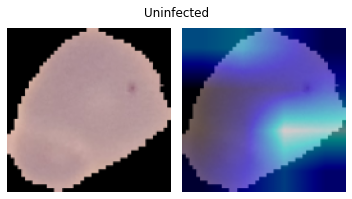

torch.Size([1, 64, 4, 4])


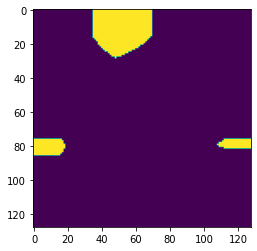

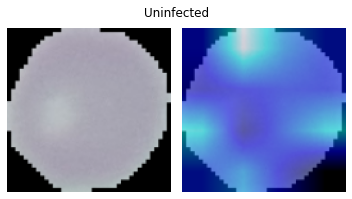

torch.Size([1, 64, 4, 4])


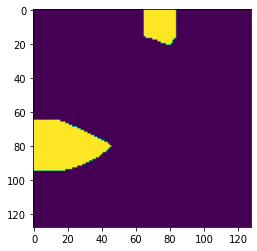

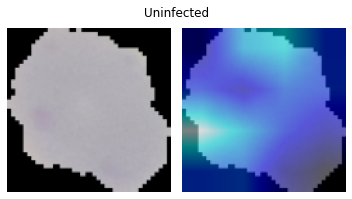

torch.Size([1, 64, 4, 4])


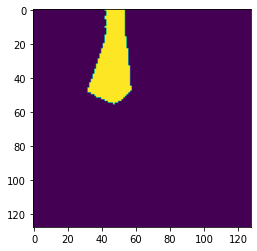

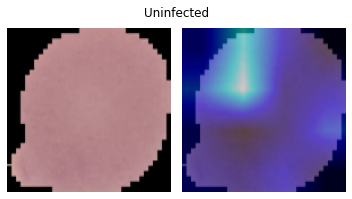

torch.Size([1, 64, 4, 4])


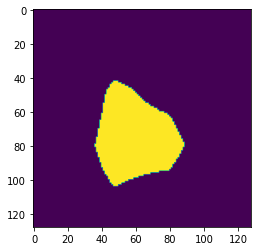

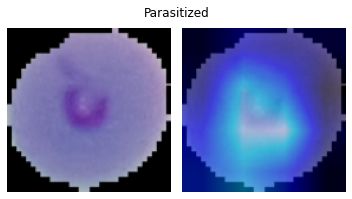

torch.Size([1, 64, 4, 4])


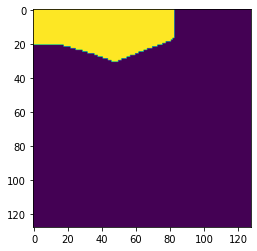

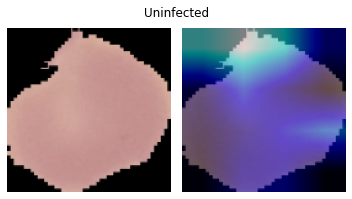

torch.Size([1, 64, 4, 4])


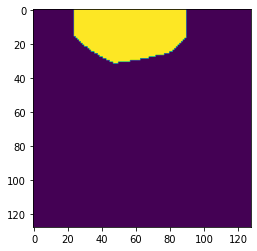

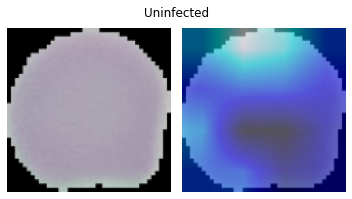

torch.Size([1, 64, 4, 4])


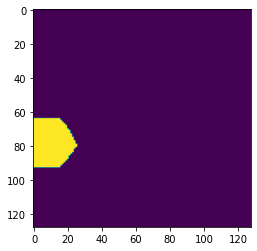

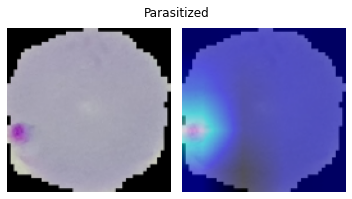

torch.Size([1, 64, 4, 4])


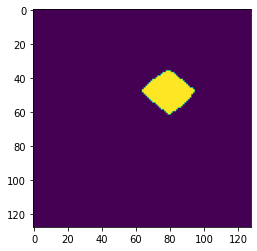

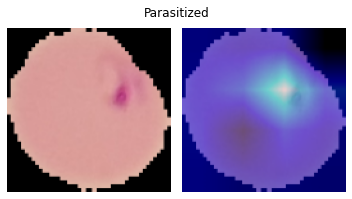

torch.Size([1, 64, 4, 4])


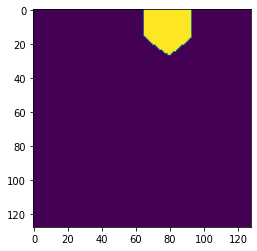

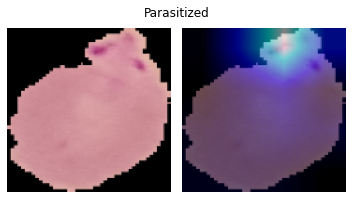

torch.Size([1, 64, 4, 4])


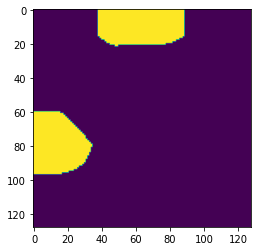

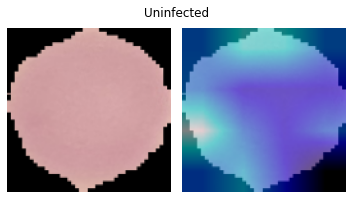

In [ ]:
N = 20
_val_dl = DataLoader(val_ds, batch_size=N, shuffle=True, collate_fn=val_ds.collate_fn)
x,y,z = next(iter(_val_dl))

for i in range(N):
    image = resize(z[i], SZ)
    heatmap, pred = im2gradCAM(x[i:i+1])
    map, thresh=upsampleHeatmap(heatmap,image)
    plt.imshow(thresh)
    subplots([image, map], nc=2, figsize=(5,3), suptitle=pred)